### 분석에 필요한 패키지 Import

In [ ]:
# 다음 코드의 주석을 해제하고 패키지를 설치해주세요.
# !pip install xgboost lightgbm catboost scikit-learn --quiet

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

SEED = 42 # random state 통일

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import (
    VotingClassifier,
    RandomForestClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, StackingClassifier
)
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

### 데이터 로드

In [8]:
# df라는 변수에 'Employee.csv' 파일을 읽어와 저장합니다.
df = pd.read_csv('Employee.csv')

In [7]:
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [10]:
target = 'LeaveOrNot'

In [12]:
X = df.iloc[:,:8] # target 컬럼을 제외한 데이터를 X에 저장합니다.
y = df[target]

In [76]:
X = df.drop(target, axis=1) # target 컬럼을 제외한 데이터를 X에 저장합니다.
y = df[target]

### 데이터 전처리

In [45]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 290.9+ KB


In [47]:
X.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain
0,Bachelors,2017,Bangalore,3,34,Male,No,0
1,Bachelors,2013,Pune,1,28,Female,No,3
2,Bachelors,2014,New Delhi,3,38,Female,No,2
3,Masters,2016,Bangalore,3,27,Male,No,5
4,Masters,2017,Pune,3,24,Male,Yes,2


In [70]:
y.head()

,LeaveOrNot
0,0
1,1
2,0
3,1
4,1


In [16]:
# 범주형 변수 전처리
# 일괄적으로 인코딩을 진행하겠습니다.

cat_cols = [
    'Education',
    'City',
    'Gender',
    'EverBenched'
]

for col in cat_cols:
    le = LabelEncoder()

    # 각 범주형 변수(col)에 대해 인코딩을 수행합니다.
    X[col] = le.fit_transform(X[col].astype(str))

In [18]:
# 스케일링

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### 훈련용 / 테스트용 데이터 분할

In [20]:
# X_scaled와 y를 훈련용과 테스트용 데이터로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y, 
    random_state=SEED
)

In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3489, 8)
(3489,)
(1164, 8)
(1164,)


## 모델링

주어진 데이터셋에 대해 단일 모델과 앙상블 기법을 각각 적용해보고 결과를 비교해봅시다.

### 단일 모델 적용

앙상블 기법을 적용하기 전에, 이전에 배웠던 단일 분류 모델들을 적용해봅시다!

(분류 기초 세션 복습 🤓)

#### 1. Logistic Regression

In [61]:
# 모델을 불러와 훈련시킵니다.
lr = LogisticRegression(random_state=SEED)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [63]:
# 모델을 통해 예측을 수행합니다.
y_lr_pred = lr.predict(X_test)

In [65]:
# 계산된 예측값에 대해 정확도를 계산합니다.
lr_accuracy = accuracy_score(y_test, y_lr_pred)
lr_report = classification_report(y_test, y_lr_pred)

print(f"Accuracy score : {lr_accuracy}")
print(f"Report :\n{lr_report}")

Accuracy score : 0.6408934707903781
Report :
              precision    recall  f1-score   support

           0       0.68      0.88      0.77       775
           1       0.41      0.16      0.23       389

    accuracy                           0.64      1164
   macro avg       0.54      0.52      0.50      1164
weighted avg       0.59      0.64      0.59      1164



#### 2. 의사결정나무

In [67]:
tree = DecisionTreeClassifier(random_state=SEED)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [69]:
y_tree_pred = tree.predict(X_test)

In [71]:
tree_accuracy = accuracy_score(y_test, y_tree_pred)
tree_report = classification_report(y_test, y_tree_pred)

print(f"Accuracy score : {tree_accuracy}")
print(f"Report :\n{tree_report}")

Accuracy score : 0.7912371134020618
Report :
              precision    recall  f1-score   support

           0       0.79      0.93      0.86       775
           1       0.78      0.52      0.63       389

    accuracy                           0.79      1164
   macro avg       0.79      0.72      0.74      1164
weighted avg       0.79      0.79      0.78      1164



#### 3. SVM

In [73]:
svm = SVC(random_state=SEED)
svm.fit(X_train, y_train)

SVC(random_state=42)

In [75]:
y_svm_pred = svm.predict(X_test)

In [77]:
svm_accuracy = accuracy_score(y_test, y_svm_pred)
svm_report = classification_report(y_test, y_svm_pred)

print(f"Accuracy score : {svm_accuracy}")
print(f"Report :\n{svm_report}")

Accuracy score : 0.8067010309278351
Report :
              precision    recall  f1-score   support

           0       0.79      0.97      0.87       775
           1       0.89      0.48      0.62       389

    accuracy                           0.81      1164
   macro avg       0.84      0.73      0.75      1164
weighted avg       0.82      0.81      0.79      1164



#### 4. kNN

In [79]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [81]:
y_knn_pred = knn.predict(X_test)

In [83]:
knn_accuracy = accuracy_score(y_test, y_knn_pred)
knn_report = classification_report(y_test, y_knn_pred)

print(f"Accuracy score : {knn_accuracy}")
print(f"Report :\n{knn_report}")

Accuracy score : 0.7525773195876289
Report :
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       775
           1       0.65      0.56      0.60       389

    accuracy                           0.75      1164
   macro avg       0.72      0.71      0.71      1164
weighted avg       0.75      0.75      0.75      1164



#### 네 가지 단일 모델의 결과 비교

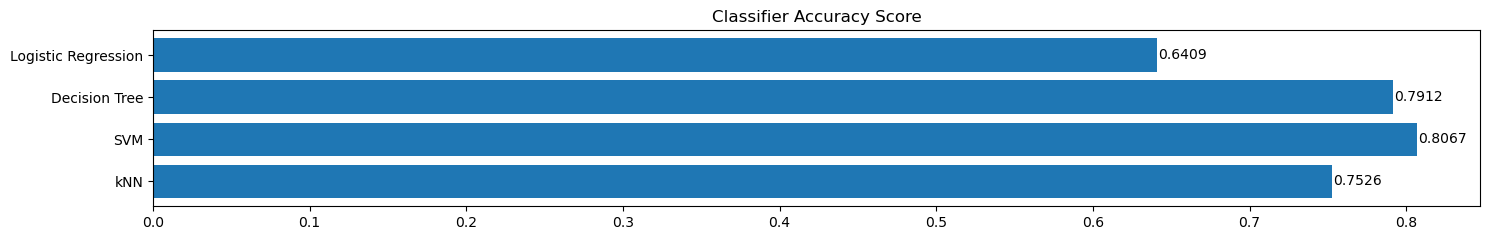

In [85]:
model_name = ['Logistic Regression', 'Decision Tree', 'SVM', 'kNN']
accuracy_scores = [lr_accuracy, tree_accuracy, svm_accuracy, knn_accuracy]

plt.figure(figsize=(15, 2.5))
bars = plt.barh(model_name[::-1], accuracy_scores[::-1])

for bar, accuracy in zip(bars, accuracy_scores[::-1]):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height() / 2, f'{accuracy:.4f}', va='center')

plt.title("Classifier Accuracy Score")
plt.xlabel("")
plt.tight_layout()
plt.show()

## 앙상블 (Ensemble)

### 1. Voting

`VotingClassifier`

- **estimators**: 사용할 기본 분류기 리스트 (이름, 모델) 형태로 지정
- **voting**: 'hard' 또는 'soft' (기본값: 'hard')
- **weights**: 각 분류기별 가중치
- **n_jobs**: 병렬 처리 수

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

In [87]:
# estimators 인자로 들어갈 분류기 리스트를 지정합니다.
models = [
    ('lr', LogisticRegression(random_state=SEED)), 
    ('dt', DecisionTreeClassifier(random_state=SEED)),
    ('rf', RandomForestClassifier(random_state=SEED))
]

In [89]:
# 모델 생성
# estimators는 models로, voting은 'hard'로 설정합니다.
voting_clf = VotingClassifier(
    estimators=models, 
    voting='hard'
)

# 모델 훈련
voting_clf.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_voting_pred = voting_clf.predict(X_test)

# 정확도 출력
print(f"Voting Accuracy: {accuracy_score(y_test, y_voting_pred):.4f}")

Voting Accuracy: 0.7973


### 2. Bagging

`RandomForestClassifier`

- **n_estimators**: 트리 개수
- **max_depth**: 트리 최대 깊이
- **max_features**: 노드 분할 시 고려할 특성 수
- **min_samples_split**: 노드 분할에 필요한 최소 샘플 수
- **bootstrap**: 부트스트랩 여부 (기본값: True)

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [91]:
# 모델 생성
rf_clf = RandomForestClassifier(random_state=SEED)

# 모델 훈련
rf_clf.fit(X_train, y_train) 

# 테스트 데이터에 대한 예측 수행
y_rf_pred = rf_clf.predict(X_test)

# 정확도 출력
print(f"Bagging (Random Forest) Accuracy: {accuracy_score(y_test, y_rf_pred):.4f}")

Bagging (Random Forest) Accuracy: 0.7964


### 3. Boosting

#### 3.1 AdaBoost

`AdaBoostClassifier`

- **estimator**: 기본 약한 학습기
- **n_estimators**: 학습기 개수
- **learning_rate**: 학습률

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

In [93]:
# 모델 생성
adaboost = AdaBoostClassifier(random_state=SEED)

# 모델 훈련
adaboost.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_ada_pred = adaboost.predict(X_test)

# 정확도 출력
print(f"AdaBoost Accuracy: {accuracy_score(y_test, y_ada_pred):.4f}")

AdaBoost Accuracy: 0.8144


#### 3.2 GBM

`GradientBoostingClassifier`

- **n_estimators**: 부스팅 단계 수
- **learning_rate**: 각 단계의 기여도
- **max_depth**: 개별 트리의 최대 깊이
- **subsample**: 학습 데이터 샘플 비율
- **min_samples_split**: 노드 분할 최소 샘플 수
- **loss**: 손실 함수 ('log_loss', 'exponential')

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [95]:
# 모델 생성
gbm = GradientBoostingClassifier(random_state=SEED)

# 모델 훈련
gbm.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_gbm_pred = gbm.predict(X_test)

# 정확도 출력
print(f"GBM Accuracy: {accuracy_score(y_test, y_gbm_pred):.4f}")

GBM Accuracy: 0.8222


#### 3.3 XGBoost

`XGBClassifier`

- **n_estimators**: 부스팅 반복 횟수
- **learning_rate**: 학습률
- **max_depth**: 트리 깊이
- **subsample**: 샘플 비율
- **colsample_bytree**: 트리당 특성 샘플 비율
- **gamma**: 분할 최소 손실 감소
- **objective**: 목적 함수 ('multi:softprob', 'binary:logistic' 등)
- **eval_metric**: 평가 지표 ('mlogloss', 'logloss', 'error' 등)

[Docs](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)

In [99]:
# 모델 생성
xgboost = xgb.XGBClassifier(random_state=SEED)

# 모델 훈련
xgboost.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_xgb_pred = xgboost.predict(X_test)

# 정확도 출력
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_xgb_pred):.4f}")

XGBoost Accuracy: 0.8119


#### 3.4 LightGBM

`LGBMClassifier`

- **n_estimators**: 트리 개수
- **learning_rate**: 학습률
- **max_depth**: 최대 깊이 (기본: -1 → 제한 없음)
- **num_leaves**: 리프 노드 수
- **subsample**: 데이터 샘플 비율
- **colsample_bytree**: 트리당 특성 샘플 비율
- **min_child_samples**: 리프 노드의 최소 샘플 수
- **objective**: 'binary', 'multiclass' 등

[Docs](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

In [101]:
# 모델 생성 (LGBMClassifier)
lgbm = lgb.LGBMClassifier(random_state=SEED, verbose=-1)

# 모델 훈련
lgbm.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_lgbm_pred = lgbm.predict(X_test)

# 정확도 출력
print(f"LightGBM Accuracy: {accuracy_score(y_test, y_lgbm_pred):.4f}")

LightGBM Accuracy: 0.8127


#### 3.5 CatBoost

`CatBoostClassifier`

- **iterations**: 부스팅 반복 횟수
- **learning_rate**: 학습률
- **depth**: 트리 깊이
- **l2_leaf_reg**: L2 정규화 계수
- **loss_function**: 손실 함수 (예: 'Logloss', 'MultiClass')
- **random_state**: 랜덤 시드
- **verbose**: 출력 제어 (0: 진행 메시지 표시하지 않음, 100: 진행률 표시)

[Docs](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier)

In [105]:
# 모델 생성
cb = CatBoostClassifier(random_state=SEED, depth=10, verbose=0)

# 모델 훈련
cb.fit(X_train,y_train)

# 테스트 데이터에 대한 예측 수행
y_cb_pred = cb.predict(X_test)

# 정확도 출력
print(f"CatBoost Accuracy: {accuracy_score(y_test, y_cb_pred):.4f}")

CatBoost Accuracy: 0.8007


### 4. Stacking

`StackingClassifier`

- **estimators**: 기본 모델 목록 (이름, 모델) 쌍의 리스트
- **final_estimator**: 최종 분류기 (기본값: LogisticRegression)
- **cv**: 교차 검증 폴드 수 (기본값: 5)
- **passthrough**: 원본 특성을 메타 모델에 전달 여부 (기본값: False)
- **n_jobs**: 병렬 처리 수

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)

In [109]:
base_learners = [
    ('lr', LogisticRegression(random_state=SEED)),
    ('dt', DecisionTreeClassifier(random_state=SEED)),
    ('rf', RandomForestClassifier(random_state=SEED))
]

stack_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator = LogisticRegression(random_state=SEED), # 최종 분류기를 LogisticRegression(random_state=SEED) 로 지정해주세요
    cv=5
)

# 모델 훈련
stack_clf.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_stk_pred = stack_clf.predict(X_test)

# 정확도 출력
print(f"Stacking Accuracy: {accuracy_score(y_test, y_stk_pred):.4f}")

Stacking Accuracy: 0.8041


## [과제] 모델 성능을 높여봅시다!

이제 직접 다른 전처리 기법, 피쳐 엔지니어링, 앙상블 기법, 추가 하이퍼파라미터 튜닝 등등.. 을 수행해서 더 높은 정확도를 가지는 모델을 만들어보세요.\
다양한 방법을 수행해보고, 비교한 후 결과를 정리해서 마크다운으로 남겨주시면 되겠습니다! 이때 각 단계별로 어떤 방법을 수행했는지에 대한 설명을 꼭 달아주세요.

- 정확도는 소수점 자릿수 제한 없이 모두 출력합니다.

### 데이터 확인 

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


In [177]:
df.describe()

,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,LeaveOrNot
count,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000
mean,2015.062970,2.698259,29.393295,2.905652,0.343864
std,1.863377,0.561435,4.826087,1.558240,0.475047
min,2012.000000,1.000000,22.000000,0.000000,0.000000
25%,2013.000000,3.000000,26.000000,2.000000,0.000000
50%,2015.000000,3.000000,28.000000,3.000000,0.000000
75%,2017.000000,3.000000,32.000000,4.000000,1.000000
max,2018.000000,3.000000,41.000000,7.000000,1.000000


In [145]:
for i in df.columns:
    print(f'{i}: {df[i].nunique()} \n {df[i].unique()}')

Education: 3 
 ['Bachelors' 'Masters' 'PHD']
JoiningYear: 7 
 [2017 2013 2014 2016 2015 2012 2018]
City: 3 
 ['Bangalore' 'Pune' 'New Delhi']
PaymentTier: 3 
 [3 1 2]
Age: 20 
 [34 28 38 27 24 22 23 37 32 39 29 30 36 31 25 26 40 35 33 41]
Gender: 2 
 ['Male' 'Female']
EverBenched: 2 
 ['No' 'Yes']
ExperienceInCurrentDomain: 8 
 [0 3 2 5 1 4 7 6]
LeaveOrNot: 2 
 [0 1]


<Axes: >

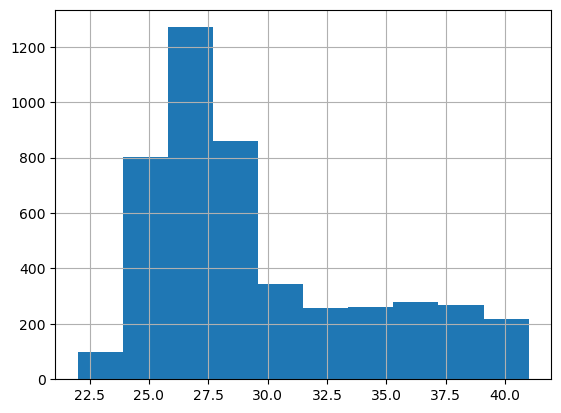

In [147]:
df['Age'].hist()

<Axes: >

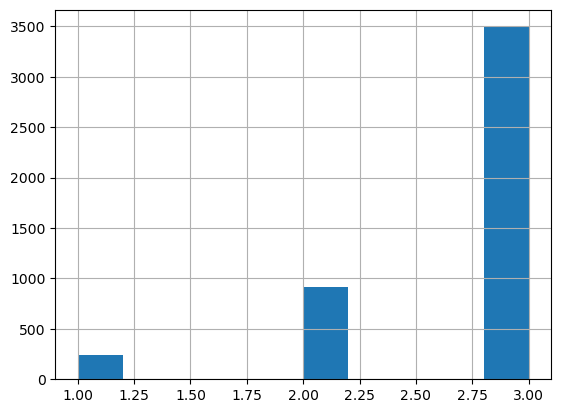

In [172]:
df['PaymentTier'].hist()

크게 전처리 할 거 없어보임 -> 바로 모델 학습으로 넘어감

### 하이퍼파라미터 최적화 준비

In [28]:
from sklearn.model_selection import GridSearchCV

### RandomForest

n_estimators: 트리 개수 (기본: 100)\
max_depth: 트리 최대 깊이\
max_features: 노드 분할 시 고려할 특성 수 (기본: 'sqrt')\
min_samples_split: 노드 분할에 필요한 최소 샘플 수\
bootstrap: 부트스트랩 여부 (기본: True)

In [339]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']}

In [341]:
grid_search = GridSearchCV(RandomForestClassifier(random_state=SEED), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

1. cv = 5
    - 교차 검증(cross validation) 5 fold

2. scoring = 'accuracy'
    - 정확도 최대화가 목적이기 때문에, accuracy 기준으로 scoring

3. n_jobs = -1
    - 사용 가능한 모든 CPU 코어 활용 (병렬 처리 최대화)

4. verbose = 1
    - 실행 중 진행 상황 출력
    - 0: 출력 없음
    - 1: 기본 정보 출력
    - 2: 각 모델 훈련 결과 출력

In [344]:
grid_search.fit(X_train,y_train)
print("Best Parameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
y_rf_t_pred = best_rf.predict(X_test)

print(f"\nRandomForest w/Tuning Accuracy: {accuracy_score(y_test, y_rf_t_pred):.4f}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 300}

RandomForest w/Tuning Accuracy: 0.8050


정확도: 0.8050 - 원래 RandomForest(0.7964)보다는 개선되었지만 최고 기록 이하

### XGBoost

- **n_estimators**: 부스팅 반복 횟수
- **learning_rate**: 학습률
- **max_depth**: 트리 깊이
- **subsample**: 샘플 비율
- **colsample_bytree**: 트리당 특성 샘플 비율
- **gamma**: 분할 최소 손실 감소
- **objective**: 목적 함수 ('multi:softprob', 'binary:logistic' 등)
- **eval_metric**: 평가 지표 ('mlogloss', 'logloss', 'error' 등)

In [346]:
param_grid = {
    'n_estimators': [100, 200],      
    'learning_rate': [0.05, 0.1],        
    'max_depth': [3, 5, 7],                    
    'subsample': [0.8, 1.0],                   
    'colsample_bytree': [0.8, 1.0],             
    'gamma': [0, 1],                           
    'scale_pos_weight': [1, 2]}

In [348]:
grid_search = GridSearchCV(xgb.XGBClassifier(random_state=SEED), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [350]:
grid_search.fit(X_train,y_train)
print("Best Parameters:", grid_search.best_params_)

best_xgb = grid_search.best_estimator_
y_xgb_t_pred = best_xgb.predict(X_test)

print(f"\nXGBoost w/Tuning Accuracy: {accuracy_score(y_test, y_xgb_t_pred):.4f}")

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 1.0}

XGBoost w/Tuning Accuracy: 0.8187


정확도: 0.8187 - 원래 XGBoost(0.8119)보다는 개선되었지만 최고 기록 이하

### AdaBoost

- **estimator**: 기본 약한 학습기
- **n_estimators**: 학습기 개수
- **learning_rate**: 학습률

In [352]:
param_grid = {
    'n_estimators': [50,100,200],
    'learning_rate': [0.01,0.1,1.0]}

In [354]:
grid_search = GridSearchCV(AdaBoostClassifier(random_state=SEED), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [356]:
grid_search.fit(X_train,y_train)
print("Best Parameters:", grid_search.best_params_)

best_ab = grid_search.best_estimator_
y_ab_t_pred = best_ab.predict(X_test)

print(f"\nAdaBoost w/Tuning Accuracy: {accuracy_score(y_test, y_ab_t_pred):.4f}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'learning_rate': 1.0, 'n_estimators': 100}

AdaBoost w/Tuning Accuracy: 0.8153


정확도: 0.8153 - 원래 AdaBoost(0.8144)보다는 개선되었지만 최고기록 이하

### GBM

- **n_estimators**: 부스팅 단계 수
- **learning_rate**: 각 단계의 기여도
- **max_depth**: 개별 트리의 최대 깊이
- **subsample**: 학습 데이터 샘플 비율
- **min_samples_split**: 노드 분할 최소 샘플 수
- **loss**: 손실 함수 ('log_loss', 'exponential')

In [358]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5],
    'loss': ['log_loss', 'exponential']}


In [360]:
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=SEED), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [362]:
grid_search.fit(X_train,y_train)
print("Best Parameters:", grid_search.best_params_)

best_gbm = grid_search.best_estimator_
y_gbm_t_pred = best_gbm.predict(X_test)

print(f"\nGBM w/Tuning Accuracy: {accuracy_score(y_test, y_gbm_t_pred):.4f}")

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}

GBM w/Tuning Accuracy: 0.8256


정확도: **0.8256** - 원래 GBM(0.8222)보다 개선되었고, 최고 기록 돌파!

### CatBoost

- **iterations**: 부스팅 반복 횟수
- **learning_rate**: 학습률
- **depth**: 트리 깊이
- **l2_leaf_reg**: L2 정규화 계수
- **loss_function**: 손실 함수 (예: 'Logloss', 'MultiClass')
- **random_state**: 랜덤 시드
- **verbose**: 출력 제어 (0: 진행 메시지 표시하지 않음, 100: 진행률 표시)

In [363]:
param_grid = {
    'iterations': [100, 200],            
    'learning_rate': [0.05, 0.1],       
    'depth': [4, 6, 8],                
    'l2_leaf_reg': [1, 3],               
    'loss_function': ['Logloss'],         
    'verbose': [0],                        
    'random_state': [42]}

In [364]:
grid_search = GridSearchCV(CatBoostClassifier(random_state=SEED), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [365]:
grid_search.fit(X_train,y_train)
print("Best Parameters:", grid_search.best_params_)

best_cb = grid_search.best_estimator_
y_cb_t_pred = best_cb.predict(X_test)

print(f"\nCatBoost w/Tuning Accuracy: {accuracy_score(y_test, y_cb_t_pred):.4f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'depth': 6, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.05, 'loss_function': 'Logloss', 'random_state': 42, 'verbose': 0}

CatBoost w/Tuning Accuracy: 0.8179


정확도: 0.8179 - 원래 CatBoost(0.8007)보다는 개선되었지만 최고기록 이하

### Soft Voting

In [377]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('ab', best_ab),
        ('gbm', best_gbm),
        ('cb', best_cb)
    ],
    voting='soft',     # 확률 기반 평균
    n_jobs=-1
)

voting_clf.fit(X_train, y_train)
y_v_pred = voting_clf.predict(X_test)

print(f"\nVoting Accuracy: {accuracy_score(y_test, y_v_pred):.4f}")


Voting Accuracy: 0.8247


정확도: 0.8247 - 지금까지 한 모델 모두 결합 -> 아쉽게도 최고기록 이하

### Stacking

In [390]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

meta_model = LogisticRegression(max_iter=1000, class_weight='balanced')

stacking_clf = StackingClassifier(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('ab', best_ab),
        ('gbm', best_gbm),
        ('cb', best_cb)
    ],
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=False)

stacking_clf.fit(X_train, y_train)
y_s_pred = stacking_clf.predict(X_test)

print(f"\nStacking Accuracy: {accuracy_score(y_test, y_s_pred):.4f}")


Stacking Accuracy: 0.7981


정확도: 0.7981 - 지금까지 한 모델 모두 결합 -> 아쉽게도 최고기록보다 매우 이하

## 1차 결과
- HyperParameter 튜닝으로 정확도를 올린 GBM 앙상블 모델
  - 1차 최종 최고 정확도: 0.8256

## 2차 시도 
- 가장 높은 정확도를 보인 GBM 모델의 하이퍼파라미터 조정해 정확도 향상 시도

In [24]:
param_grid = {
    'n_estimators': [100, 130, 150, 180, 200],
    'learning_rate': [0.05, 0.075, 0.1, 0.15],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0, 1.2],
    'min_samples_split': [2, 3, 4, 5],
    'loss': ['log_loss', 'exponential']}


In [30]:
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=SEED), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [32]:
grid_search.fit(X_train,y_train)
print("Best Parameters:", grid_search.best_params_)

best_gbm = grid_search.best_estimator_
y_gbm_t_pred = best_gbm.predict(X_test)

print(f"\nGBM w/Tuning Accuracy: {accuracy_score(y_test, y_gbm_t_pred):.4f}")

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
Best Parameters: {'learning_rate': 0.05, 'loss': 'log_loss', 'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 100, 'subsample': 1.0}

GBM w/Tuning Accuracy: 0.8746


정확도: **0.8746** - 큰 폭의 정확도 향상!, 최고 기록 갱신

In [34]:
param_grid = {
    'n_estimators': [90, 100, 110],
    'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1],
    'max_depth': [4, 5, 6, 7],
    'subsample': [0.9, 1.0, 1.1],
    'min_samples_split': [3, 4, 5],
    'loss': ['log_loss', 'exponential']}


In [36]:
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=SEED), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [38]:
grid_search.fit(X_train,y_train)
print("Best Parameters:", grid_search.best_params_)

best_gbm = grid_search.best_estimator_
y_gbm_t_pred = best_gbm.predict(X_test)

print(f"\nGBM w/Tuning Accuracy: {accuracy_score(y_test, y_gbm_t_pred):.4f}")

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Best Parameters: {'learning_rate': 0.05, 'loss': 'log_loss', 'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 90, 'subsample': 0.9}

GBM w/Tuning Accuracy: 0.8737


In [40]:
param_grid = {
    'n_estimators': [90, 95, 100, 105, 110],
    'learning_rate': [0.025, 0.05, 0.075],
    'max_depth': [5, 6, 7],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [3, 4, 5],
    'loss': ['log_loss', 'exponential']}


In [42]:
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=SEED), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [44]:
grid_search.fit(X_train,y_train)
print("Best Parameters:", grid_search.best_params_)

best_gbm = grid_search.best_estimator_
y_gbm_t_pred = best_gbm.predict(X_test)

print(f"\nGBM w/Tuning Accuracy: {accuracy_score(y_test, y_gbm_t_pred):.4f}")

Fitting 5 folds for each of 810 candidates, totalling 4050 fits
Best Parameters: {'learning_rate': 0.05, 'loss': 'log_loss', 'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 90, 'subsample': 0.9}

GBM w/Tuning Accuracy: 0.8737


In [50]:
param_grid = {
    'n_estimators': [110, 130, 150, 170],
    'learning_rate': [0.05, 0.075, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.9, 1.0, 1.1],
    'min_samples_split': [3, 4, 5, 6],
    'loss': ['log_loss', 'exponential']}


In [52]:
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=SEED), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [54]:
grid_search.fit(X_train,y_train)
print("Best Parameters:", grid_search.best_params_)

best_gbm = grid_search.best_estimator_
y_gbm_t_pred = best_gbm.predict(X_test)

print(f"\nGBM w/Tuning Accuracy: {accuracy_score(y_test, y_gbm_t_pred):.4f}")

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
Best Parameters: {'learning_rate': 0.05, 'loss': 'log_loss', 'max_depth': 4, 'min_samples_split': 3, 'n_estimators': 130, 'subsample': 1.0}

GBM w/Tuning Accuracy: 0.8763


정확도: **0.8763** - 또 최고 기록 갱신!

In [58]:
param_grid = {
    'n_estimators': [200, 250, 300],
    'learning_rate': [0.02, 0.03, 0.04],
    'max_depth': [3, 4, 5],
    'subsample': [0.9, 1.0],
    'min_samples_split': [2, 3, 4],
    'validation_fraction': [0.1],
    'n_iter_no_change': [5],
    'loss': ['log_loss']
}


In [60]:
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=SEED), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [62]:
grid_search.fit(X_train,y_train)
print("Best Parameters:", grid_search.best_params_)

best_gbm = grid_search.best_estimator_
y_gbm_t_pred = best_gbm.predict(X_test)

print(f"\nGBM w/Tuning Accuracy: {accuracy_score(y_test, y_gbm_t_pred):.4f}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'learning_rate': 0.02, 'loss': 'log_loss', 'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 250, 'n_iter_no_change': 5, 'subsample': 0.9, 'validation_fraction': 0.1}

GBM w/Tuning Accuracy: 0.8763


또 동일하게 0.8763 - 하이퍼파라미터 조정으로는 최대한으로 정확도를 올린 듯 하다

# 2차 결과
- HyperParameter 튜닝으로 정확도를 더 올린 GBM 앙상블 모델
  - 최종 최고 정확도: **0.8763**